# Script to plot THz streaking trace and calibrate streaking slope at SwissFEL Alvra
- General documentation https://docs.google.com/document/d/1Ll3_WsHzFwuvL-sWgqWQUSYKJRgFG6W7PWY-NJ40WS0/edit?usp=sharing
- User guide ADD WEBSITE
- Comments to christopher.arrell@psi.ch

### Setup

In [2]:
import photodiag
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import json
import os

from scipy.special import erf
from scipy.optimize import curve_fit
from IPython.display import clear_output, display

In [3]:
def LoadData(fn):
    with h5.File(fn, 'r') as f:
        TOF = -f['SAROP11-PALMK118:CH2_BUFFER/data'][:]
        uTOF = -f['SAROP11-PALMK118:CH1_BUFFER/data'][:]
        PulseIds = f['SAROP11-PALMK118:CH2_BUFFER/pulse_id'][:]
# for 50Hz the following
        index_laser = np.logical_and((PulseIds+2)%4 == 0, PulseIds != 0)
        TOFM = TOF.mean(axis=0)
        eVIntP = palm.etofs['1'].convert(
        input_data=TOF[index_laser],
        interp_energy=palm.energy_range
        )
        eVIntUp = palm.etofs['0'].convert(
        input_data=uTOF[index_laser],
        interp_energy=palm.energy_range
        )
    return(eVIntP, eVIntUp,TOF[index_laser], uTOF[index_laser])

def fitfunc(x, a, b, c, d, e, f):
    return a + b*np.exp(-(c-x)**2/np.abs(d)**2)*np.sin(e*x + f)  
def linfitfunc(x,a, b):
    return a+b*x
def findindexabs(dataIn):
    ind = np.argmin(np.abs(dataIn))
    return ind

### User inputs


In [4]:
energyFrom = 600
energyTo = 850
energySteps = 1000
CalibrationFn = f'/sf/alvra/data/p17983/res/PhotoDiag/scan_info/2019-07-23_09:02:52.palm_etof'
ScanFn = '/sf/alvra/data/p17983/res/scan_info/PALM_scan_0058_scan_info.json'

Change fn below, if the following error is displayed:
JSONDecodeError: Expecting value: line 1 column 1 (char 0)retry - its just the file isn't yet where ra looks


### Setup and load data

In [5]:
palm = photodiag.PalmSetup(
    channels={'0': 'SAROP11-PALMK118:CH1_BUFFER', '1': 'SAROP11-PALMK118:CH2_BUFFER'},
    noise_range=[0, 250], energy_range=np.linspace(energyFrom, energyTo, energySteps),
)
palm.load_etof_calib(CalibrationFn)

with open(ScanFn) as f:
    data = json.load(f)
numFiles = len(data['scan_files'])
StagePOS = data['scan_values'][:]

eVIntP = []
eVIntUp = []
bwf_str = []
wf_ref = []
wf_str = []


for i in range(0,numFiles):
    (tmpP, tmpUp, tmpwf_str, tmpwf_ref) = LoadData(str(data['scan_files'][i][0]))
    eVIntP.append(tmpP)
    eVIntUp.append(tmpUp)
    wf_str.append(tmpwf_str)
    wf_ref.append(tmpwf_ref)
    clear_output(wait=True)
    print('Loaded file %s' %str(data['scan_files'][i][0]))
eVIntP = np.array(eVIntP)
eVIntUp = np.array(eVIntUp)
wf_str = np.array(wf_str)
wf_ref = np.array(wf_ref)

Datasize = str(wf_str.shape)
print('Data size %s, expecting 1 x 3 '%Datasize)

StagePOS = np.array(StagePOS)
Stagefs = (StagePOS[:,0]*1e-3*2/3e8)*1e15

Loaded file /sf/alvra/data/p17983/raw/scan_data/PALM_scan_0058/PALM_scan_0058_step0030.BSREAD.h5
Data size (31, 25, 2000), expecting 1 x 3 


### Plot and fit THz waveform

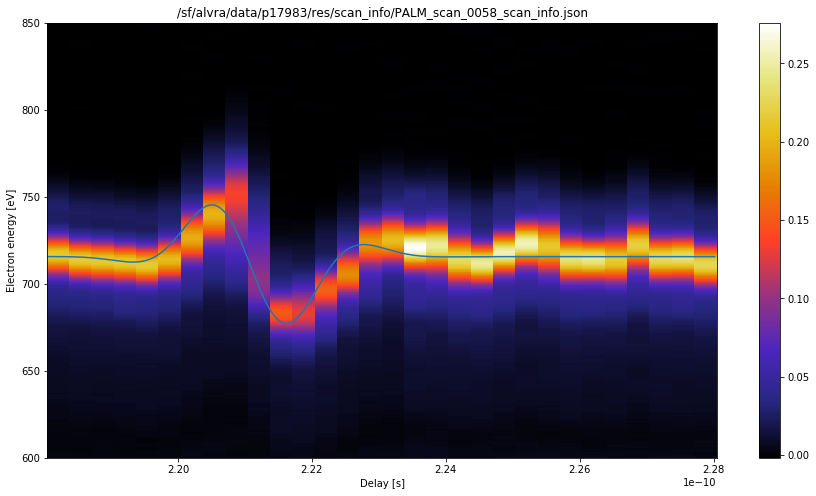

For scan /sf/alvra/data/p17983/res/scan_info/PALM_scan_0058_scan_info.json, t0 from phase = 2.2121404186181136e-10 s and peak to peak streak of 68.1 eV


In [9]:
p0Energy = palm.energy_range[np.argmax(eVIntP[0,0,:])]
p0Streak = 70
p0t0 = 2.21e-10
parameters,extras = curve_fit(fitfunc,StagePOS[:,0],palm.energy_range[np.argmax(np.transpose(eVIntP.mean(axis=1)),axis =0)], 
                              p0 = [p0Energy,p0Streak,p0t0,1e-12,2.8e12,1])
# make the derivative 
dx = StagePOS[1,0]-StagePOS[2,0]
d_fitfunc_dx = np.gradient(fitfunc(StagePOS[:,0],*parameters), dx)/np.max(np.gradient(fitfunc(StagePOS[:,0],*parameters), dx))

max_y = np.max(np.gradient(fitfunc(StagePOS[:,0],*parameters)))  # Find the maximum y value
max_x = np.argmin(np.gradient(fitfunc(StagePOS[:,0],*parameters)))  # Find the maximum y value

# t0 from the phase fit 
t0_from_phase = parameters[2] + (parameters[4]*parameters[5])**-1 

# Trace from fit
xS=np.arange(np.min(StagePOS[:,0]),np.max(StagePOS[:,0]),(np.max(StagePOS[:,0])-np.min(StagePOS[:,0]))/300)
ySFitted=[fitfunc(x, parameters[0],parameters[1],parameters[2],parameters[3],parameters[4],parameters[5]) for x in xS]

# Plot
fig = plt.figure(figsize=(15,8))
plt.pcolormesh(StagePOS[:,0], palm.energy_range, np.transpose(eVIntP.mean(axis=1)), cmap='CMRmap')
plt.colorbar()
plt.plot(xS,ySFitted)
plt.xlabel('Delay [s]')
plt.ylabel('Electron energy [eV]')
plt.title(ScanFn)
plt.show()
PeakToPeak = np.max(ySFitted)-np.min(ySFitted)
print('For scan '+ScanFn + ', t0 from phase = %s s and peak to peak streak of %.1f eV'%(t0_from_phase, PeakToPeak))

### Fit THz gradient

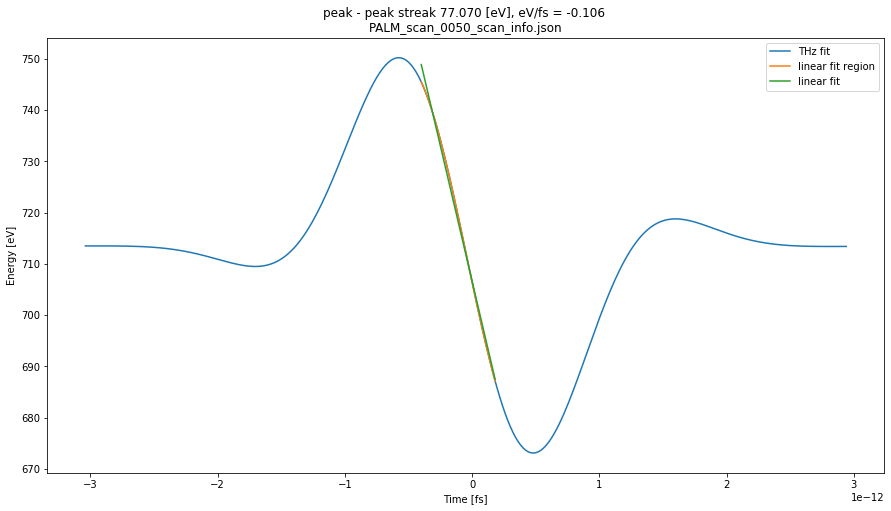

In [24]:
ind_1 = np.argmin(abs((xS+400e-15)-parameters[2]))
ind_t0 = np.argmin(abs(xS-parameters[2]))
ind_2 = np.argmin(abs((xS-200e-15)-parameters[2]))
paras,extras = curve_fit(linfitfunc,xS[ind_1:ind_2]-parameters[2],ySFitted[ind_1:ind_2], 
                    p0 = [700e-8,-80/800e-12])#,bounds=param_bounds)
Trace_lin_fit = linfitfunc(xS[ind_1:ind_2]-parameters[2],*paras)
calib = paras[1]*1e-15

plt.figure(figsize=(15,8))
plt.plot(xS-parameters[2],ySFitted, label = 'THz fit')
plt.plot(xS[ind_1:ind_2]-parameters[2],ySFitted[ind_1:ind_2], label = 'linear fit region')
plt.plot(xS[ind_1:ind_2]-parameters[2], Trace_lin_fit, label = 'linear fit')
plt.xlabel('Time [fs]')
plt.ylabel('Energy [eV]')
plt.title('peak - peak streak %.3f [eV], eV/fs = %.3f \n'%(PeakToPeak, calib) + ScanFn[46:] )
tmp = plt.legend()